<a href="https://colab.research.google.com/github/maryisangediok/Fraud-Detection/blob/main/smoteennCCFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

## Train and test using SMOTEENN resampled dataset

# Google Drive Access Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import sys, os
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import StratifiedShuffleSplit 
from xgboost import XGBClassifier
import xgboost
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Preps**

In [ ]:
# Read the CSV file
data_path = '/content/drive/MyDrive/creditcard/creditcard.csv'
data = pd.read_csv(data_path)

In [ ]:
#Normalize Amount
data['normAmount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))
data['normTime'] = StandardScaler().fit_transform(np.array(data['Time']).reshape(-1,1))

# Now dropping Time and Amount as they'll be irrelevant for our prediction
data = data.drop(['Amount', 'Time'], axis = 1)

In [ ]:
# Separate labels from features
X = data.loc[:,data.columns!='Class']
y = data['Class']
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train_smoteenn, y_train_smoteenn = SMOTEENN().fit_resample(X_train,y_train)

In [ ]:
r_ = float(np.sum(y==0)) / np.sum(y==1)
ratio = np.sqrt(np.sum(y==0)) / np.sum(y==1)
#scale_pos_weight = sqrt(count(negative examples)/count(Positive examples)) #since dataset is extremely unbalanced, using a more conservative ratio

In [ ]:
print(X_train.shape, y_train[y==1].shape)

(227845, 30) (394,)


In [ ]:
print(f"Proportion of fraudulent transaction in the training set is {394/227845}")

Proportion of fraudulent transaction in the training set is 0.001729245759178389


In [ ]:
print(X_test.shape, y_test[y==1].shape)

(56962, 30) (98,)


In [ ]:
print(f"Proportion of fraudulent transaction in the test set is {98/56962}")

Proportion of fraudulent transaction in the test set is 0.0017204452090867595


# Train Model

In [ ]:
def fit_model_and_get_predictions(classifier, X_train_smoteenn, y_train_smoteenn, X_test, y_test,
                                  scale=True):
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(X_train_smoteenn, y_train_smoteenn)
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(X_test)[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(X_train_smoteenn)[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [12]:
classifiers_dictionary={'Logistic regression+smoteenn':sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                                                          penalty='l2',
                                                                                          max_iter=100,
                                                                                          #class_weight='balanced',
                                                                                          C=3,
                                                                                          random_state=0), 
                        'Decision tree+smoteenn':sklearn.tree.DecisionTreeClassifier(criterion='entropy',
                                                                                random_state=0), 
                        'Random forest+smoteenn':sklearn.ensemble.RandomForestClassifier(max_depth=6,
                                                                                    n_estimators=50,
                                                                                    oob_score=True,
                                                                                    warm_start=True,
                                                                                    random_state=0),
                        'XGBoost+smoteenn':xgboost.XGBClassifier(max_depth=12,
                                                            n_estimators=100,
                                                            learning_rate=0.1,
                                                            gamma=0.3,
                                                            scale_pos_weight=ratio,
                                                            colsample_bytree=0.9,
                                                            random_sate=0),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
  start_time=time.time()
  model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], X_train_smoteenn, y_train_smoteenn, X_test, y_test)
  fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions
  
  print("Time to fit the "+classifier_name+" model: "+str(round(time.time()-start_time,2)))
  fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

Time to fit the Logistic regression+smoteenn model: 11.54
Time to fit the Decision tree+smoteenn model: 39.21
Time to fit the Random forest+smoteenn model: 126.74
Time to fit the XGBoost+smoteenn model: 529.26


In [13]:
%%capture
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

In [14]:
%%capture
roc_curve, ax = plt.subplots(1, 1, figsize=(5,5))

cmap = plt.get_cmap('jet')
colors={'Logistic regression+smoteenn':cmap(0),
        'Decision tree+smoteenn':cmap(250),
        'Random forest+smoteenn':cmap(70),
        'XGBoost+smoteenn':cmap(40)}

get_template_roc_curve(ax,title='Receiver Operating Characteristic Curve\nTest data',fs=15)
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(y_test, model_and_predictions['predictions_test'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    #ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    ax.legend(loc = 'best',bbox_to_anchor=(1.05, 1))
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)

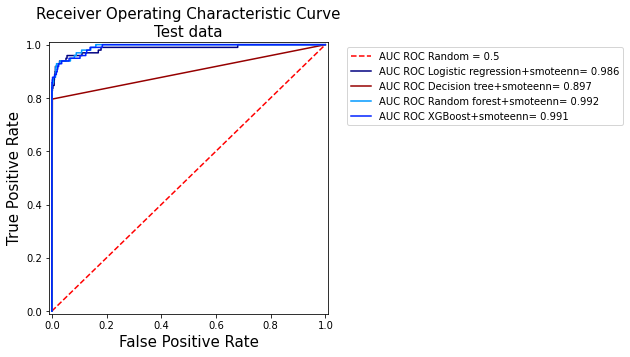

In [15]:
roc_curve

In [16]:
def compute_AP(precision, recall):    
    AP = 0
    n_thresholds = len(precision)
    for i in range(1, n_thresholds):
      if recall[i]-recall[i-1]>=0:
        AP = AP+(recall[i]-recall[i-1])*precision[i]
    return AP

In [17]:
%%capture
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

In [18]:
%%capture
pr_curve, ax = plt.subplots(1, 1, figsize=(6,6))
cmap = plt.get_cmap('jet')
colors={'Logistic regression+smoteenn':cmap(0),
        'Decision tree+smoteenn':cmap(250),
        'Random forest+smoteenn':cmap(70),
        'XGBoost+smoteenn':cmap(40)}

get_template_pr_curve(ax, "Precision Recall (PR) Curve\nTest data",fs=15,baseline=sum(y_test)/len(y_test))
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(y_test, model_and_predictions['predictions_test'])
    precision=precision[::-1]
    recall=recall[::-1]
    
    AP = metrics.average_precision_score(y_test, model_and_predictions['predictions_test'])
    
    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    #ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    ax.legend(loc = 'best',bbox_to_anchor=(1.05, 1))    
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)

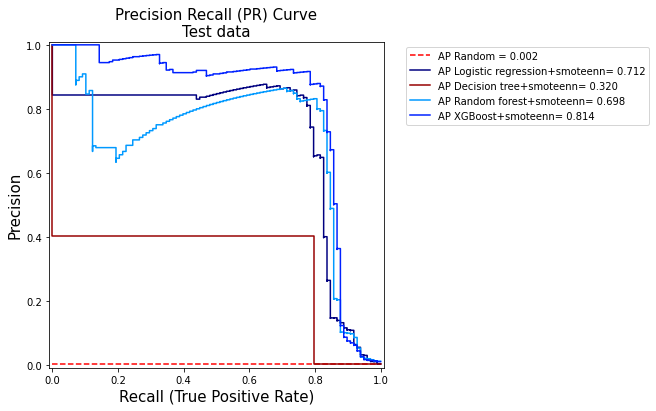

In [19]:
pr_curve